# Bayesian optimization with fixed features
In some contexts a variable/feature needs to be fixed during optimization. However, we
can leverage previous measurements near the fixed variable value to potentially
jump-start optimization using observed model covariances established by the GP kernel
. In this example, we start with a number of random observations in 2D input space
and then proceed with BO at a fixed value for one of the variables. This notebook
uses the 2D Rosenbrock test function as an example.

In [1]:
# set values if testing
import os
SMOKE_TEST = os.environ.get("SMOKE_TEST")
NUM_MC_SAMPLES = 1 if SMOKE_TEST else 128
NUM_RESTARTS = 1 if SMOKE_TEST else 20

# Ignore all warnings
import warnings
warnings.filterwarnings("ignore")

from xopt import Xopt, Evaluator
from xopt.generators.bayesian import UpperConfidenceBoundGenerator
from xopt.resources.test_functions.rosenbrock import evaluate_rosenbrock,make_rosenbrock_vocs

# make rosenbrock function vocs in 2D
vocs = make_rosenbrock_vocs(2)

# define a fixed value for the BO generator
fixed_features = {"x0":-1.0}
generator = UpperConfidenceBoundGenerator(
    vocs=vocs, fixed_features=fixed_features
)
generator.numerical_optimizer.n_restarts = NUM_RESTARTS
generator.n_monte_carlo_samples = NUM_MC_SAMPLES

evaluator = Evaluator(function=evaluate_rosenbrock)

X = Xopt(generator=generator, evaluator=evaluator, vocs=vocs)
X


            Xopt
________________________________
Version: 2.0a1+22.g2b84a31.dirty
Data size: 0
Config as YAML:
xopt: {asynch: false, strict: true, dump_file: null, max_evaluations: null}
generator:
  name: upper_confidence_bound
  model: null
  turbo_controller: null
  use_cuda: false
  gp_constructor:
    name: standard
    use_low_noise_prior: true
    covar_modules: {}
    mean_modules: {}
    trainable_mean_keys: []
  numerical_optimizer: {name: LBFGS, n_raw_samples: 20, n_restarts: 20, max_iter: 2000}
  max_travel_distances: null
  fixed_features: {x0: -1.0}
  n_monte_carlo_samples: 128
  beta: 2.0
evaluator:
  function: xopt.resources.test_functions.rosenbrock.evaluate_rosenbrock
  max_workers: 1
  function_kwargs: {label: y, dummy: 1}
  vectorized: false
vocs:
  variables:
    x0: [-2.0, 2.0]
    x1: [-2.0, 2.0]
  constraints: {}
  objectives: {y: MINIMIZE}
  constants: {}
  observables: []


## Generate some initial random samples in 2D space

In [2]:
X.random_evaluate(10)

,x0,x1,y,xopt_runtime,xopt_error
1,1.172452,-0.762759,456.878657,0.000010,False
2,-1.884476,0.425693,985.231490,0.000004,False
3,1.590982,1.128042,197.241535,0.000003,False
4,1.866620,-1.491263,2476.343937,0.000003,False
5,0.935013,0.313953,31.397371,0.000003,False
6,-1.762782,0.543722,664.877801,0.000002,False
7,1.225056,0.057427,208.372024,0.000002,False
8,-1.149352,-1.867066,1021.002166,0.000003,False
9,0.567123,-1.071774,194.344382,0.000002,False
10,-1.587333,1.900191,45.064522,0.000002,False


## Run BO steps with fixed features

In [3]:
for i in range(5):
    X.step()

In [4]:
X.data

,x0,x1,y,xopt_runtime,xopt_error
1,1.172452,-0.762759,456.878657,0.000010,False
2,-1.884476,0.425693,985.231490,0.000004,False
3,1.590982,1.128042,197.241535,0.000003,False
4,1.866620,-1.491263,2476.343937,0.000003,False
5,0.935013,0.313953,31.397371,0.000003,False
6,-1.762782,0.543722,664.877801,0.000002,False
7,1.225056,0.057427,208.372024,0.000002,False
8,-1.149352,-1.867066,1021.002166,0.000003,False
9,0.567123,-1.071774,194.344382,0.000002,False
10,-1.587333,1.900191,45.064522,0.000002,False


## Visualize model and evaluations
Note that for the BO samples, they all are on the line $x_0=-1$

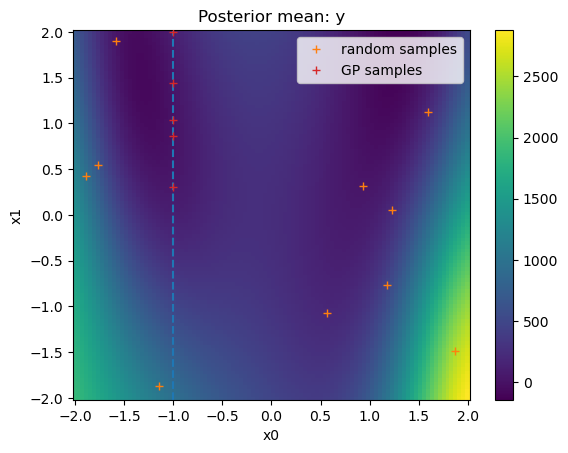

In [5]:
from matplotlib import pyplot as plt  # plot model predictions
import torch
data = X.data

bounds = X.generator.vocs.bounds
model = X.generator.train_model(generator.data)

# create mesh
n = 100
x = torch.linspace(*bounds.T[0], n)
y = torch.linspace(*bounds.T[1], n)
xx, yy = torch.meshgrid(x, y)
pts = torch.hstack([ele.reshape(-1, 1) for ele in (xx, yy)]).double()

outputs = generator.vocs.output_names
with torch.no_grad():
    post = model.posterior(pts)

    for i in range(len(vocs.output_names)):
        mean = post.mean[...,i]
        fig, ax = plt.subplots()
        ax.plot(*data[["x0", "x1"]].to_numpy()[:10].T, "+C1",
                label="random samples",
                zorder=10
                )
        ax.plot(*data[["x0", "x1"]].to_numpy()[10:].T, "+C3",
                label="GP samples",
                zorder=10)


        c = ax.pcolor(
            xx, yy, mean.squeeze().reshape(n, n)
        )
        fig.colorbar(c)
        ax.set_title(f"Posterior mean: {outputs[i]}")
        ax.axvline(-1.0,ls="--")
        ax.set_xlabel("x0")
        ax.set_ylabel("x1")
        ax.legend()